In [ ]:
!git clone https://github.com/JoabFelippx/PA2_train_model.git

Cloning into 'PA2_train_model'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 27 (delta 7), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (27/27), 1.54 MiB | 4.70 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
!pip install -r /content/PA2_train_model/requirements.txt

In [ ]:
!unzip -o /content/PA2_train_model/dataset.zip -d /content/

Archive:  /content/PA2_train_model/dataset.zip
   creating: /content/dataset/
   creating: /content/dataset/valid/
   creating: /content/dataset/valid/junior/
  inflating: /content/dataset/valid/junior/junior_face_8.jpg  
  inflating: /content/dataset/valid/junior/junior_face_9.jpg  
  inflating: /content/dataset/valid/junior/junior_face_7.jpg  
  inflating: /content/dataset/valid/junior/junior_face_2.jpg  
  inflating: /content/dataset/valid/junior/junior_face_5.jpg  
  inflating: /content/dataset/valid/junior/junior_face_3.jpg  
  inflating: /content/dataset/valid/junior/junior_face_11.jpg  
  inflating: /content/dataset/valid/junior/junior_face_4.jpg  
  inflating: /content/dataset/valid/junior/junior_face_6.jpg  
  inflating: /content/dataset/valid/junior/junior_face_10.jpg  
   creating: /content/dataset/valid/gustavo/
  inflating: /content/dataset/valid/gustavo/gustavo_face_9.jpg  
  inflating: /content/dataset/valid/gustavo/gustavo_face_6.jpg  
  inflating: /content/dataset/vali

In [ ]:
import os

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
# size of the image
TGSIZE = (224, 224)
input_shape = (224, 224, 3)

In [ ]:
dataset_path = '/content/dataset' # path to the dataset folder

In [ ]:
train_dir = f'{dataset_path}/train'
valid_dir = f'{dataset_path}/valid'
test_dir = f'{dataset_path}/test'

In [ ]:
train_junior_dir = os.path.join(train_dir, 'junior')
train_gustavo_dir = os.path.join(train_dir, 'gustavo')

In [ ]:
valid_junior_dir = os.path.join(valid_dir, 'junior')
valid_gustavo_dir = os.path.join(valid_dir, 'gustavo')

In [ ]:
test_junior_dir = os.path.join(test_dir, 'junior')
test_gustavo_dir = os.path.join(test_dir, 'gustavo')

train and validation generator with data augmentation

In [ ]:
def train_valid_generator(train_dir, valid_dir):

    train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, horizontal_flip=True, fill_mode='nearest')
    valid_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_dir, target_size=TGSIZE, batch_size=20, class_mode='binary')
    valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=TGSIZE, batch_size=20, class_mode='binary')

    return train_generator, valid_generator

In [ ]:
train_generator, valid_generator = train_valid_generator(train_dir, valid_dir)

Found 75 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [ ]:
# load the VGG16 model
def create_pretrained_model():

    pre_trained_model_vgg16 = VGG16(input_shape=input_shape, weights=None, include_top=False)

    for layer in pre_trained_model_vgg16.layers:
        layer.trainable = False

    return pre_trained_model_vgg16

In [ ]:
pre_trained_model_vgg16 = create_pretrained_model()

In [ ]:
# show the model summary
pre_trained_model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# callback to stop the training when the accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs={}):

    if(logs.get('accuracy')>0.999):
      print("\nAtingi 99,9% de precisão, portanto, estou cancelando o treinamento!!")
      self.model.stop_training = True

In [ ]:
# output of the last layer of the VGG16 model
def output_last_layer(pre_trained_model_vgg16):

    last_layer = pre_trained_model_vgg16.get_layer('block5_pool')
    last_output = last_layer.output

    return last_output

In [ ]:
last_output = output_last_layer(pre_trained_model_vgg16)

In [ ]:
# create the final model
def create_final_model(pre_trained_model_vgg16, last_output):

    x = tf.keras.layers.Flatten()(last_output)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = tf.keras.Model(pre_trained_model_vgg16.input, x)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model = create_final_model(pre_trained_model_vgg16, last_output)

In [ ]:
callbacks = myCallback()
history = model.fit(train_generator, validation_data=valid_generator, epochs=100, verbose=2, callbacks=[callbacks])

Epoch 1/100
4/4 - 6s - loss: 0.6916 - accuracy: 0.5333 - val_loss: 0.6801 - val_accuracy: 0.5000 - 6s/epoch - 2s/step
Epoch 2/100
4/4 - 1s - loss: 0.6846 - accuracy: 0.5600 - val_loss: 0.6730 - val_accuracy: 0.5000 - 1s/epoch - 290ms/step
Epoch 3/100
4/4 - 1s - loss: 0.6757 - accuracy: 0.5600 - val_loss: 0.6667 - val_accuracy: 0.5000 - 1s/epoch - 281ms/step
Epoch 4/100
4/4 - 1s - loss: 0.6719 - accuracy: 0.5600 - val_loss: 0.6610 - val_accuracy: 0.5000 - 1s/epoch - 278ms/step
Epoch 5/100
4/4 - 1s - loss: 0.6612 - accuracy: 0.5600 - val_loss: 0.6537 - val_accuracy: 0.5000 - 1s/epoch - 277ms/step
Epoch 6/100
4/4 - 1s - loss: 0.6496 - accuracy: 0.5733 - val_loss: 0.6452 - val_accuracy: 0.5000 - 1s/epoch - 279ms/step
Epoch 7/100
4/4 - 1s - loss: 0.6448 - accuracy: 0.6267 - val_loss: 0.6372 - val_accuracy: 0.6000 - 1s/epoch - 271ms/step
Epoch 8/100
4/4 - 1s - loss: 0.6337 - accuracy: 0.8133 - val_loss: 0.6262 - val_accuracy: 0.6000 - 1s/epoch - 349ms/step
Epoch 9/100
4/4 - 2s - loss: 0.6209

In [1]:
model.save('/content/models/model_weight.h5')

NameError: name 'model' is not defined

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
epochs = range(len(acc))

<Figure size 640x480 with 0 Axes>

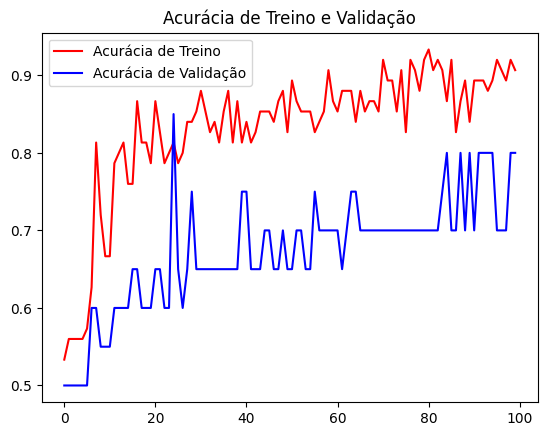

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(epochs, acc, 'r', label='Acurácia de Treino')
plt.plot(epochs, val_acc, 'b', label='Acurácia de Validação')
plt.title('Acurácia de Treino e Validação')
plt.legend(loc=0)
plt.figure()

In [ ]:
plt.show()

In [66]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
from random import shuffle

images_JUNIOR = [os.path.join(test_junior_dir, f) for f in os.listdir(test_junior_dir)]
images_GUSTAVO = [os.path.join(test_gustavo_dir, f) for f in os.listdir(test_gustavo_dir)]

all_images = []
all_images.extend(images_GUSTAVO)
all_images.extend(images_JUNIOR)


shuffle(all_images)
for img in all_images:
    try:
      image = load_img(img, target_size=TGSIZE)
      x = img_to_array(image)
      x = x / 255.0
      x = np.expand_dims(x, axis=0)
      images = np.vstack([x])

      classes = model.predict(images, batch_size=10)

      if classes[0][0]>0.5:
        print(img + " é um GUSTAVO")
        print('Com uma precisão de ' + classes[0][0])
      else:
        print(img + " é um JUNIOR")
        print('Com uma precisão de ' + classes[0][1])
    except:
      pass



1/1 [==============================] - 0s 33ms/step
/content/dataset/test/junior/junior_face_30.jpg é um JUNIOR
1/1 [==============================] - 0s 28ms/step
/content/dataset/test/gustavo/gustavo_face_55.jpg é um GUSTAVO
1/1 [==============================] - 0s 37ms/step
/content/dataset/test/junior/junior_face_17.jpg é um JUNIOR
1/1 [==============================] - 0s 32ms/step
/content/dataset/test/junior/junior_face_36.jpg é um JUNIOR
1/1 [==============================] - 0s 31ms/step
/content/dataset/test/junior/junior_face_13.jpg é um JUNIOR
1/1 [==============================] - 0s 22ms/step
/content/dataset/test/junior/junior_face_52.jpg é um JUNIOR
1/1 [==============================] - 0s 18ms/step
/content/dataset/test/gustavo/gustavo_face_40.jpg é um GUSTAVO
1/1 [==============================] - 0s 20ms/step
/content/dataset/test/junior/junior_face_45.jpg é um JUNIOR
1/1 [==============================] - 0s 22ms/step
/content/dataset/test/junior/junior_face_59.jp